In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1")
data.head(50)
data = data.fillna(method="ffill")
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())
words=list(data['Word'].unique())
words.append("ENDPAD")
num_words = len(words)
tags=list(data['Tag'].unique())
num_tags = len(tags)
print("Unique tags are:", tags)
num_words = len(words)
num_tags = len(tags)
num_words

Unique words in corpus: 9216
Unique tags in corpus: 17
Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


<ipython-input-2-d5429bcd8d80>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


9217

In [3]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


<ipython-input-3-ec4b8e38ba61>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


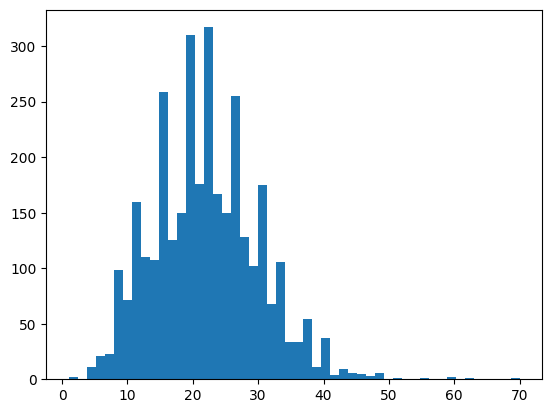

In [4]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)
sentences[0]
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
word2idx
plt.hist([len(s) for s in sentences], bins=50)
plt.show()
X1 = [[word2idx[w[0]] for w in s] for s in sentences]
type(X1[0])
X1[0]
max_len = 50

In [5]:
X = sequence.pad_sequences(maxlen=max_len,
                  sequences=X1, padding="post",
                  value=num_words-1)
X[0]
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
y = sequence.pad_sequences(maxlen=max_len,
                  sequences=y1,
                  padding="post",
                  value=tag2idx["O"])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)
X_train[0]
y_train[0]


array([0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [8]:
input_word = layers.Input(shape=(max_len,))
model = layers.Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = layers.Bidirectional(layers.LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = layers.TimeDistributed(layers.Dense(num_tags, activation="softmax"))(model)

model = Model(input_word, model)
print('Name:VASUNDRA SRI R Register Number: 212222230168')
model.summary()

Name:VASUNDRA SRI R Register Number: 212222230168


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 50)              │         460,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,067 (2.23 MB)

 Trainable params: 585,067 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test,y_test),
    batch_size=32,
    epochs=3,
)

Epoch 1/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 252ms/step - accuracy: 0.9504 - loss: 0.1582 - val_accuracy: 0.9537 - val_loss: 0.1593
Epoch 2/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - accuracy: 0.9642 - loss: 0.1203 - val_accuracy: 0.9632 - val_loss: 0.1351
Epoch 3/3
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9742 - loss: 0.0930 - val_accuracy: 0.9694 - val_loss: 0.1178


In [17]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.953235,0.148029,0.953697,0.159315
1,0.965917,0.116461,0.963151,0.135119
2,0.975273,0.088757,0.969394,0.117790


Name:VASUNDRA SRI R  Register Number:212222230168      


<Axes: >

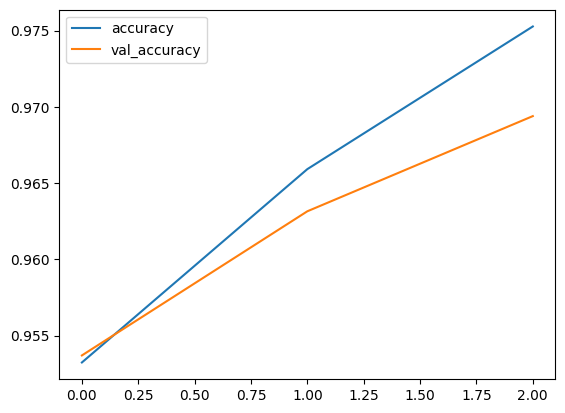

In [18]:
print('Name:VASUNDRA SRI R  Register Number:212222230168      ')
metrics[['accuracy','val_accuracy']].plot()

Name:VASUNDRA SRI R  Register Number:212222230168       


<Axes: >

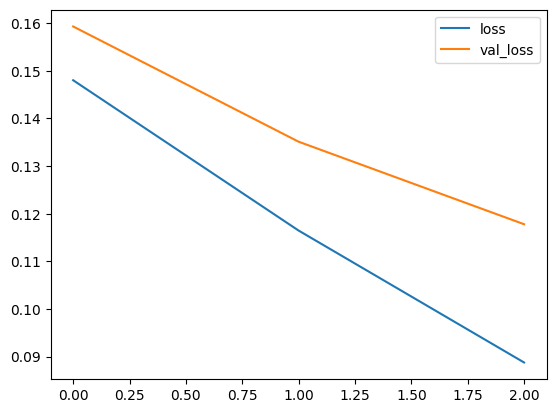

In [19]:
print('Name:VASUNDRA SRI R  Register Number:212222230168       ')
metrics[['loss','val_loss']].plot()

In [13]:
i = 14
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print('Name:VASUNDRA SRI R Register Number: 212222230168')
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Name:VASUNDRA SRI R Register Number: 212222230168
Word           True 	 Pred

------------------------------
An             O	O
agreement      O	O
signed         O	O
last           O	O
year           O	O
with           O	O
the            O	O
European       B-org	O
Union          I-org	B-geo
is             O	O
pending        O	O
,              O	O
but            O	O
a              O	O
deal           O	O
with           O	O
the            O	O
United         B-geo	B-geo
States         I-geo	B-geo
has            O	O
been           O	O
stalled        O	O
in             O	O
Congress       B-org	B-geo
since          O	O
2007           B-tim	B-geo
because        O	O
of             O	O
concerns       O	O
from           O	O
the            O	O
American       B-gpe	B-geo
beef           O	O
and            O	O
auto           O	O
industries     O	O
.              O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
cards          O	O
car